In [1]:
import os, sys, re
from functools import partial
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bibtexparser.latexenc import string_to_latex

sys.path.insert(1, os.path.join(sys.path[0], '..'))

import database
from snowballing.operations import load_work_map_all_years, work_to_bibtex, reload
from snowballing.operations import match_bibtex_to_work
from snowballing.approaches import get_approaches, name, wlatex_name, wcitea
reload()

all_approaches = get_approaches()
script = [(a, m) for a, m in all_approaches if not m["binary"]]
binary = [(a, m) for a, m in all_approaches if m["binary"]]
len(script)

27

In [2]:
{y for a, m in all_approaches for y in m["annotations"]}

{Definition,
 Exclusive,
 Executable,
 External,
 Inclusive,
 Internal,
 Mandatory,
 Optional,
 Parseable,
 Provenance,
 —}

In [3]:
{y for a, m in all_approaches for y in m["execution"]}

{Instrumentation, Overriding, Passive Monitoring, Post-Mortem, —}

In [4]:
{y for a, m in all_approaches for y in m["deployment"]}

{Continuous, Snapshot, —}

In [5]:
{y for a, m in all_approaches for y in m["definition"]}

{Dynamic, Execution, Parsing, Reading, Static, —}

In [6]:
with open('../../csur/bibliography.bib') as bibtex_file:
    bibtex_str = bibtex_file.read()

matched = match_bibtex_to_work(bibtex_str.split("%Entries")[-1])
works = dict(map(reversed, matched))
latex_name = partial(wlatex_name, works=works)
citea = partial(wcitea, works=works)

In [7]:
from database.groups import INTERNAL, EXTERNAL, PARSEABLE, EXECUTABLE, INCLUSIVE, EXCLUSIVE, NA
from database.groups import PROVENANCE, DEFINITION, OPTIONAL, MANDATORY
from database.groups import PASSIVE_MONITORING, OVERRIDING, POST_MORTEM, INSTRUMENTATION
from database.groups import SNAPSHOT, CONTINUOUS
from database.groups import READING, PARSING, STATIC, DYNAMIC, ASKS

from database.groups import YES, NO

def select(element, field):
    try:
        index = field.index(element)
        element = field[index]
        if hasattr(element, "_star") and element._star is not None:
            return element
        return YES
    except ValueError:
        if NA in field:
            return NA
        return NO
    
def find(elements, abrevs, field):
    for element, abrev in zip(elements, abrevs):
        try:
            index = field.index(element)
            if (hasattr(element, "_star") and element._star is not None) or abrev is None:
                yield element
            yield abrev
        except ValueError:
            pass

writer = pd.ExcelWriter('output/gathering.xlsx')
dfs = {}

for mode_name, mode in [("binary", binary), ("script", script), ]:

    name_header = ["Approach", "Latex Name", "Granularity"]
    name_extra = ["Approach"] + [""] * 2
    name_data = [
        [
            name(approach),
            latex_name(approach), 
            string_to_latex(meta['granularity_text'])
        ]
        for approach, meta in mode
    ]
    
    annotations_header = ["Approach", "Placement", "Extraction", "Inclusiveness", "Target", "Necessity"]
    annotations_extra = ["Approach"] + ["Annotations"] * 5
    annotations_data = [
        [
            name(approach), 
            ", ".join(map(str, find((INTERNAL, EXTERNAL, NA), ("Inte", "Exte", NA), meta["annotations"]))) or NO,
            ", ".join(map(str, find((PARSEABLE, EXECUTABLE, NA), ("Pars", "Exec", NA), meta["annotations"]))) or NO,
            ", ".join(map(str, find((INCLUSIVE, EXCLUSIVE, NA), ("Incl", "Excl", NA), meta["annotations"]))) or NO,
            ", ".join(map(str, find((DEFINITION, PROVENANCE, NA), ("Defi", "Prov", NA), meta["annotations"]))) or NO,
            ", ".join(map(str, find((MANDATORY, OPTIONAL, NA), ("Man", "Opt", NA), meta["annotations"]))) or NO,
        ]
        for approach, meta in mode
    ]
    
    execution_header = ["Approach", PASSIVE_MONITORING, OVERRIDING, POST_MORTEM, INSTRUMENTATION]
    execution_header = list(map(str, execution_header))
    execution_extra = ["Approach"] + ["Execution"] * 4
    execution_data = [
        [
            name(approach), 
            select(PASSIVE_MONITORING, meta["execution"]),
            select(OVERRIDING, meta["execution"]),
            select(POST_MORTEM, meta["execution"]),
            select(INSTRUMENTATION, meta["execution"]),
        ]
        for approach, meta in mode
    ]

    deployment_header = ["Approach", "Snapshot", "Continuous"]
    deployment_extra = ["Approach"] + ["Deployment"] * 2
    deployment_data = [
        [
            name(approach),
            select(SNAPSHOT, meta["deployment"]),
            select(CONTINUOUS, meta["deployment"]),
        ]
        for approach, meta in mode
    ]

    definition_header = ["Approach", "Reading", "Parsing", "Static", "Dynamic"]
    definition_extra = ["Approach"] + ["Definition"] * 4
    definition_data = [
        [
            name(approach),
            select(READING, meta["definition"]),
            select(PARSING, meta["definition"]),
            select(STATIC, meta["definition"]),
            select(DYNAMIC, meta["definition"]),
            #select(ASKS, meta["definition"]),
        ]
        for approach, meta in mode
    ]
    
    names = pd.DataFrame.from_records(
        [name_header] +
        [list(map(str, elements)) for elements in name_data],
        columns=name_header,
    )
    names = names.set_index("Approach")

    annotations = pd.DataFrame.from_records(
        [annotations_header] +
        [list(map(str, elements)) for elements in annotations_data],
        columns=annotations_header,
    )
    annotations = annotations.set_index("Approach")

    execution = pd.DataFrame.from_records(
        [execution_header] +
        [list(map(str, elements)) for elements in execution_data],
        columns=execution_header,
    )
    execution = execution.set_index("Approach")

    deployment = pd.DataFrame.from_records(
        [deployment_header] +
        [list(map(str, elements)) for elements in deployment_data],
        columns=deployment_header,
    )
    deployment = deployment.set_index("Approach")

    definition = pd.DataFrame.from_records(
        [definition_header] +
        [list(map(str, elements)) for elements in definition_data],
        columns=definition_header,
    )
    definition = definition.set_index("Approach")

    df = pd.concat([names, annotations, execution, deployment, definition], axis=1)
    df.index.name = None
    df.columns = name_header[1:] + annotations_extra[1:] + execution_extra[1:] + deployment_extra[1:] + definition_extra[1:]
    edf = df.drop('Latex Name', 1)
    edf.to_excel(writer,mode_name)
    dfs[mode_name] = df
    
writer.save()

In [8]:
dfs["script"]

,Latex Name,Granularity,Annotations,Annotations,Annotations,Annotations,Annotations,Execution,Execution,Execution,Execution,Deployment,Deployment,Definition,Definition,Definition,Definition
Approach,Latex Name,Granularity,Placement,Extraction,Inclusiveness,Target,Necessity,Passive Monitoring,Overriding,Post-Mortem,Instrumentation,Snapshot,Continuous,Reading,Parsing,Static,Dynamic
Astro-WISE,Astro-WISE,"User defined, Attributes, Files (I/O), Paramet...",Inte,Exec,Incl,Defi,Man,✗,✗,✗,✓,✗,✗,✓,✗,✗,✓
Becker and Chambers,\citet{becker1988a},"Commands, Variables, Random Seed",✗,✗,✗,✗,✗,✗,✓,✗,✗,✗,✗,✗,✗,✗,✓
"Bochner, Gude, and Schreiber",\citet{bochner2008a},"User defined, Files, Platform",Inte,Exec,Incl,Defi,Man,✗,✗,✗,✓,✗,✓,✓,✗,✗,✓
CPL,CPL,N/A,—,—,—,—,—,—,—,—,—,—,—,—,—,—,—
CXXR,CXXR,"Commands, Variables, Random Seed, Files (I)",✗,✗,✗,✗,✗,✗,✓,✗,✗,✗,✗,✗,✗,✗,✗
Datatrack,Datatrack,"User defined, Parameters, Platform, Modules",Inte,Exec,Incl,"Defi, Prov","Man, Opt",✗,✗,✗,✓,✗,✓,✗,✗,✗,✗
ES3,ES3,Files (I/O - metadata),✗,✗,✗,✗,✗,✗,✓,✗,✗,✗,✗,✗,✗,✗,✗
ESSW,ESSW,"User defined, Processes, Files (I/O)",Inte,Exec,Incl,Defi,Man,✗,✗,✗,✓,✗,✗,✓,✗,✗,✓
IncPy,IncPy,"Functions, Globals, Stack, Output, Files (I/O)",Inte,Exec,"Incl, Excl",Defi,Opt,✗,✓,✗,✓,✗,✗,✓,✓,✓,✓


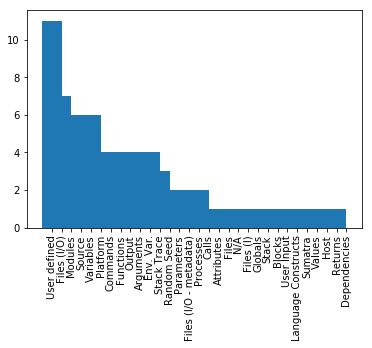

In [9]:
c = Counter()
for x in name_data:
    c.update(x[2].split(', '))
c.most_common()

labels, values = zip(*c.most_common())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels, rotation='vertical')
plt.show()

In [10]:
header = r"""\begin{longtable}[t]{|N{0.14\textwidth}|L{0.2\textwidth}|U?U?U?U?U|T?T?T?T|T?T|T?T?T?T|}
  \caption{Provenance collection strategies. Labels in Annotations columns refer to categories described in Section~\ref{sec:annotations} \emph{Exte} \textemdash External; \emph{Inte} \textemdash Internal; \emph{Pars} \textemdash Parseable; \emph{Exec} \textemdash Executable; \emph{Incl} \textemdash Inclusive; \emph{Excl} \textemdash Exclusive; \emph{Defi} \textemdash Definition; \emph{Prov} \textemdash Provenance; \emph{Man} \textemdash Mandatory; \emph{Opt} \textemdash Optional.}
  \label{tab:script-collection}\\
  \hline
  \rowcolor{BlueRow}
  \multicolumn{1}{|c|}{\textbf{Approach}} & \multicolumn{1}{c|}{\textbf{Granularity}} & \multicolumn{5}{c|}{\textbf{Annotations}} & \multicolumn{4}{c|}{\textbf{Execution}} & \multicolumn{2}{c|}{\textbf{Depl.}} & \multicolumn{4}{c|}{\textbf{Definition}}\\
  \hline
  
  & & \rot{\textbf{Placement}} & \rot{\textbf{Extraction}} & \rot{\textbf{Inclusiveness}} & \rot{\textbf{Target}} & \rot{\textbf{Necessity}} & \rot{\textbf{Passive Monitoring  }  } & \rot{\textbf{Overriding}} & \rot{\textbf{Post-Mortem}} & \rot{\textbf{Instrumentation}} & \rot{\textbf{Snapshot}} & \rot{\textbf{Continuous}} & \rot{\textbf{Reading}} & \rot{\textbf{Parsing}} & \rot{\textbf{Static}} & \rot{\textbf{Dynamic}}\\
  \hline
  \endfirsthead
  \hline
  \rowcolor{BlueRow}
  \multicolumn{1}{|c|}{\textbf{Approach}} & \multicolumn{1}{c|}{\textbf{Granularity}} & \multicolumn{5}{c|}{\textbf{Annotations}} & \multicolumn{4}{c|}{\textbf{Execution}} & \multicolumn{2}{c|}{\textbf{Depl.}} & \multicolumn{4}{c|}{\textbf{Definition}}\\
  \hline
  
  & & \rot{\textbf{Placement}} & \rot{\textbf{Extraction}} & \rot{\textbf{Inclusiveness}} & \rot{\textbf{Target}} & \rot{\textbf{Necessity}} & \rot{\textbf{Passive Monitoring  }  } & \rot{\textbf{Overriding}} & \rot{\textbf{Post-Mortem}} & \rot{\textbf{Instrumentation}} & \rot{\textbf{Snapshot}} & \rot{\textbf{Continuous}} & \rot{\textbf{Reading}} & \rot{\textbf{Parsing}} & \rot{\textbf{Static}} & \rot{\textbf{Dynamic}}\\
  \hline
  \endhead
  \hline \multicolumn{17}{|r|}{{Continued on next page}} \\ \hline
  \endfoot
  \endlastfoot
"""
footer = r"""
\end{longtable}
"""


In [11]:
def condense(row, initial, size, func=None):
    if func is None:
        def func(x, i, last):
            if x == r"\na":
                return r"\na"
            if x != r"\false":
                return r"\true"
            return r"\false"
    CONVERT = {
        "✗": r"\false",
        "✓": r"\true",
        "—": r"\na"
    }
    result = [func(CONVERT.get(x, x), i, size - 1) for i, x in enumerate(row[1][initial:initial+size])]
    #if len(set(result)) == 1:
    if len(result) == 1:
        result = ["\multicolumn{{{}}}{{c|}}{{{}}}".format(size, result[0])]
    return " & ".join(result)

In [12]:
def annotations_func(x, i, last):
    if x == r"\false":
        return x
    if x == r"\true":
        return x
    if x in (r"\na", "—"):
        return r"\na"
    return "\\textcolor{{GreenMark}}{{\\tiny{{{}}}}}".format(
        ' '.join(y.strip()[:4] for y in x.split(','))
    )
annotations = lambda row: condense(
    row, 2, 5,
    func=annotations_func)
            
execution = lambda row: condense(row, 7, 4)
deployment = lambda row: condense(row, 11, 2)
definition = lambda row: condense(row, 13, 4)
print(execution(list(dfs['script'].iterrows())[4]))

\na & \na & \na & \na


In [13]:
iterrows = dfs['script'].iterrows()
next(iterrows)
result = []
for i, row in enumerate(iterrows):
    if i % 2 == 0:
        result.append(r"  \rowcolor{BlueRow}")
    result.append("  " + " & ".join([
        row[1][0], row[1][1], annotations(row), execution(row), deployment(row), definition(row)
    ]) + r"\\")
    #result.append(r"  \arrayrulecolor{LightBlueLine}\hline")
result.append("  \hline")

In [14]:
latex = header + "\n" + "\n".join(result) + "\n" + footer
with open("../../csur/figs/script_collection.tex", "w") as goals:
    goals.write(latex)

In [15]:
manual = "" #  "SisGExp"
if manual:

    caption = r"""
    \begin{table}[t]
      \caption{Provenance collection strategies. Labels in Annotations columns refer to categories described in Section~\ref{sec:annotations} \emph{Exte} \textemdash External; \emph{Inte} \textemdash Internal; \emph{Pars} \textemdash Parseable; \emph{Exec} \textemdash Executable; \emph{Incl} \textemdash Inclusive; \emph{Excl} \textemdash Exclusive; \emph{Defi} \textemdash Definition; \emph{Prov} \textemdash Provenance; \emph{Man} \textemdash Mandatory; \emph{Opt} \textemdash Optional.}
      \label{tab:script-collection}
    """
    head = r"""
      \small{
      \begin{tabular}[!htbp]{|N{0.13\textwidth}|L{0.2\textwidth}|U?U?U?U?U|T?T?T?T|T?T|T?T?T?T|}
        \hline
        \rowcolor{BlueRow}
        \multicolumn{1}{|c|}{\textbf{Approach}} & \multicolumn{1}{c|}{\textbf{Granularity}} & \multicolumn{5}{c|}{\textbf{Annotation}} & \multicolumn{4}{c|}{\textbf{Execution}} & \multicolumn{2}{c|}{\textbf{Depl.}} & \multicolumn{4}{c|}{\textbf{Definition}}\\
        \hline
        & & \rot{\textbf{Placement}} & \rot{\textbf{Extraction}} & \rot{\textbf{Inclusiveness}} & \rot{\textbf{Target}} & \rot{\textbf{Necessity}} & \rot{\textbf{Passive Monitoring  }  } & \rot{\textbf{Overriding}} & \rot{\textbf{Post-Mortem}} & \rot{\textbf{Instrumentation}} & \rot{\textbf{Snapshot}} & \rot{\textbf{Continuous}} & \rot{\textbf{Reading}} & \rot{\textbf{Parsing}} & \rot{\textbf{Static}} & \rot{\textbf{Dynamic}}\\
        \hline
    """
    foot = r"""
        \hline \multicolumn{17}{|r|}{{Continued on next page}} \\ \hline
      \end{tabular}
      }
    \end{table}
    \begin{table}[t]
    """
    footer = r"""
        \hline
      \end{tabular}
      }
    \end{table}
    """

    iterrows = dfs['script'].iterrows()
    next(iterrows)
    result = [caption, head]
    for i, row in enumerate(iterrows):
        if i % 2 == 0:
            result.append(r"  \rowcolor{BlueRow}")
        result.append("    " + " & ".join([
            row[1][0], row[1][1], annotations(row), execution(row), deployment(row), definition(row)
        ]) + r"\\")
        if row[1][0] == manual:
            result.append(foot)
            result.append(head)        
    result.append(footer)

    latex = "\n".join(result)
    with open("../csur/figs/script_collection.tex", "w") as goals:
        goals.write(latex)